In [154]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import random
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [155]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [156]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [246]:
import numpy as np
import math
class NeuralNetBatch:
    def __init__(self,hidden_layer, normalize = True, learning_rate = 0.01, num_iter = 30000, batch_size = 32):
        self.hidden_layer = hidden_layer
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.batch_size = batch_size
    
    def mini_batches(self, X, Y):
        m = X.shape[1] 
        mini_batch_size = self.batch_size
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1,m))

        num_complete_minibatches = math.floor(m/mini_batch_size)
        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:]
            mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)

        return mini_batches

    
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        self.parameters = {}
        l = len(n_x)
        
        for i in range(1, l):
            W = np.random.randn(n_x[i], n_x[i - 1]) * 0.01
            b = np.zeros((n_x[i], 1))
            self.parameters.update({f"W{i}": W, f"b{i}": b})

        W = np.random.randn(1, n_x[l-1]) * 0.01
        b = 0
        
        self.parameters.update({f"W{l}":W, f"b{l}":b})
        
    def __forward_propagation(self, X):
        layers_count = len(self.hidden_layer)
        cache = self.parameters.copy()
        
        A = X
        for i in range(1, layers_count + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            Z = np.dot(W, A) + b
            A = self.__sigmoid(Z)
            cache.update({f"Z{i}": Z})
            cache.update({f"A{i}": A})
        return A, cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        layers_count = len(self.hidden_layer)
        
        grads = {}
        A = cache[f"A{layers_count+1}"]
        A_next = cache[f"A{layers_count}"]
                
        dZ = A - Y
        dW = 1. / m * np.dot(dZ, A_next.T)
        db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
        grads.update({f"dZ{layers_count+1}":dZ, f"dW{layers_count+1}":dW, f"db{layers_count+1}":db})
        for i in range(layers_count, 0, -1):
            W = cache[f"W{i}"]
            b = cache[f"b{i}"]
            Z = cache[f"Z{i}"]
                
            if (i == 1):
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                dA = np.dot(W_prev.T, dZ)

                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, X.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            else:
                W_prev = cache[f"W{i + 1}"]
                A = cache[f"A{i}"]
                A_next = cache[f"A{i - 1}"]

                dA = np.dot(W_prev.T, dZ)
                dZ = np.multiply(dA, np.multiply(A, 1 - A))
                dW = 1. / m * np.dot(dZ, A_next.T)
                db = 1. / m * np.sum(dZ, axis = 1, keepdims = True)
            grads.update({f"dZ{i}":dZ, f"dW{i}":dW, f"db{i}":db})
        return grads
    
    def __update_parameters(self, grads):
        layers_count = len(self.hidden_layer)
        
        for i in range(1, layers_count + 2):
            W = self.parameters[f"W{i}"]
            b = self.parameters[f"b{i}"]
            
            dW = grads[f"dW{i}"]
            db = grads[f"db{i}"]
            
            self.parameters[f"W{i}"] = W - self.learning_rate * dW
            self.parameters[f"b{i}"] = b - self.learning_rate * db

        
    def fit(self, X_vert, Y_vert, epsilon = 10e-6,print_cost = True):
        X,Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
      
        
        costs = []
        n = len(Y)
        n_x = (X.shape[0],) + self.hidden_layer
        self.__initialize_parameters(n_x)
        for i in range(self.num_iter):
            minibatches = self.mini_batches(X, Y)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                a3, caches = self.__forward_propagation(minibatch_X)

                cost = self.compute_cost(a3, minibatch_Y)

                grads = self.__backward_propagation(minibatch_X, minibatch_Y, caches)
                
                self.__update_parameters(grads)
            if print_cost and i % 1000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
        if print_cost:
            print("Cost after iteration %i: %f" %(i,cost))
        
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        print(probs)
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

In [247]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


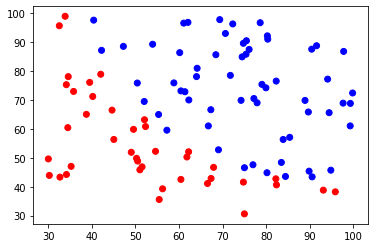

In [248]:
plot_data(X, Y)

In [249]:
cls = NeuralNetBatch((200,),normalize = True, learning_rate = 0.1, num_iter = 5000)

Cost after iteration 0: 0.836670
Cost after iteration 1000: 0.691076
Cost after iteration 2000: 0.752334
Cost after iteration 3000: 0.117452
Cost after iteration 4000: 0.090758
Cost after iteration 4999: 0.011371


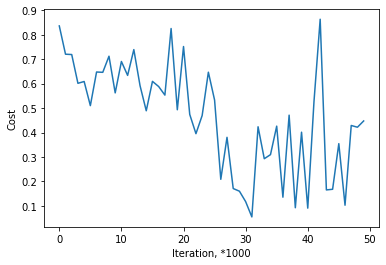

In [250]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [215]:
print(cls.parameters)

{'W1': array([[-4.31163493e-01, -3.80755266e-01],
       [ 1.04107799e+00,  9.15524217e-01],
       [ 8.56232014e-01,  7.16937784e-01],
       [-5.24610499e-01, -4.55266123e-01],
       [-1.11292200e+00, -9.80172614e-01],
       [-1.63098895e+00, -1.42216305e+00],
       [-4.29651210e-01, -3.78900466e-01],
       [-2.15188593e-01, -1.77423399e-01],
       [-1.14118480e+00, -1.00484250e+00],
       [-5.16365440e-01, -4.64713713e-01],
       [-2.78832572e-01, -2.41584697e-01],
       [-4.56964807e-01, -4.13237564e-01],
       [-9.99371969e-01, -8.66991644e-01],
       [ 3.67091150e-01,  3.04581230e-01],
       [ 1.06700927e-02,  4.82931248e-03],
       [-1.02718801e+00, -8.68644982e-01],
       [-6.86057785e-01, -5.93261908e-01],
       [-7.64090424e-01, -6.98354624e-01],
       [-1.23913202e+00, -1.09312771e+00],
       [-1.32358179e+00, -1.17334246e+00],
       [-8.38919936e-01, -7.23118683e-01],
       [ 1.02675911e+00,  9.15417597e-01],
       [ 8.46820141e-02,  8.23577164e-02],
    

In [216]:
Y_prob = cls.predict_proba(X)
Y_prob

[[1.66328688e-01 7.17639085e-04 1.02087858e-01 9.70914183e-01
  9.91690764e-01 3.95744733e-02 9.94186003e-01 4.88296668e-01
  9.97759771e-01 7.20915231e-01 8.72003430e-01 8.45018181e-02
  9.95712371e-01 9.98608571e-01 2.40073555e-01 9.51811928e-01
  4.87286337e-01 2.47851290e-01 9.97704426e-01 5.99071207e-01
  1.46821480e-01 9.93376738e-01 3.08365247e-02 1.35781409e-03
  9.75409328e-01 8.07150586e-01 6.19884526e-01 8.29634350e-01
  1.79363430e-01 5.30766183e-02 8.47269875e-01 9.55981016e-01
  2.45675514e-01 4.48138190e-01 1.47038050e-01 8.84749053e-02
  7.91260021e-01 9.65363388e-01 3.07429931e-01 1.10403483e-01
  9.39321216e-01 2.69820298e-02 9.96677231e-01 5.51401619e-01
  2.16243995e-02 2.32075442e-01 9.77823857e-01 9.99907470e-01
  9.95163175e-01 9.99822096e-01 9.91409704e-01 9.96896792e-01
  8.65640636e-01 1.47568054e-02 3.39901966e-02 1.20018592e-01
  9.98735336e-01 6.56705609e-01 9.62445952e-01 9.84206451e-01
  9.96825389e-01 2.39842329e-03 1.84047066e-02 1.58038720e-03
  1.4533

array([[1.66328688e-01, 8.33671312e-01],
       [7.17639085e-04, 9.99282361e-01],
       [1.02087858e-01, 8.97912142e-01],
       [9.70914183e-01, 2.90858171e-02],
       [9.91690764e-01, 8.30923591e-03],
       [3.95744733e-02, 9.60425527e-01],
       [9.94186003e-01, 5.81399708e-03],
       [4.88296668e-01, 5.11703332e-01],
       [9.97759771e-01, 2.24022917e-03],
       [7.20915231e-01, 2.79084769e-01],
       [8.72003430e-01, 1.27996570e-01],
       [8.45018181e-02, 9.15498182e-01],
       [9.95712371e-01, 4.28762891e-03],
       [9.98608571e-01, 1.39142908e-03],
       [2.40073555e-01, 7.59926445e-01],
       [9.51811928e-01, 4.81880716e-02],
       [4.87286337e-01, 5.12713663e-01],
       [2.47851290e-01, 7.52148710e-01],
       [9.97704426e-01, 2.29557363e-03],
       [5.99071207e-01, 4.00928793e-01],
       [1.46821480e-01, 8.53178520e-01],
       [9.93376738e-01, 6.62326233e-03],
       [3.08365247e-02, 9.69163475e-01],
       [1.35781409e-03, 9.98642186e-01],
       [9.754093

In [251]:
Y_hat = cls.predict(X)
Y_hat

[[1.35170005e-01 5.61391150e-04 8.15261769e-02 9.62528902e-01
  9.88981873e-01 3.07097649e-02 9.92470390e-01 4.15775962e-01
  9.97038411e-01 6.56210717e-01 8.32582714e-01 6.39474677e-02
  9.94286437e-01 9.98176416e-01 1.97577616e-01 9.38675912e-01
  4.16744295e-01 1.98209550e-01 9.96987314e-01 5.26777197e-01
  1.14203650e-01 9.91089631e-01 2.36961178e-02 1.05599504e-03
  9.67546662e-01 7.61449455e-01 5.47516125e-01 7.80897381e-01
  1.41706922e-01 4.16858447e-02 8.09155096e-01 9.41638568e-01
  1.99743830e-01 3.84370062e-01 1.18137138e-01 6.87706449e-02
  7.50179137e-01 9.55202055e-01 2.48279757e-01 8.85340323e-02
  9.20084311e-01 2.06813174e-02 9.95499013e-01 4.76014628e-01
  1.65567196e-02 1.85939690e-01 9.70744965e-01 9.99873205e-01
  9.93727143e-01 9.99758829e-01 9.88595828e-01 9.95768996e-01
  8.25664430e-01 1.15215746e-02 2.61536321e-02 9.46822461e-02
  9.98278410e-01 6.02316268e-01 9.50829919e-01 9.79284705e-01
  9.95807896e-01 1.86258945e-03 1.39796890e-02 1.23582393e-03
  1.1610

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [252]:
accuracy_score(Y, Y_hat)

0.9

[[8.04586764e-05 8.92947521e-05 9.91071369e-05 ... 9.99979853e-01
  9.99981846e-01 9.99983640e-01]]


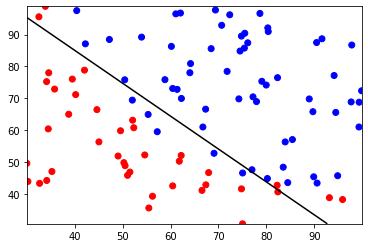

In [253]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [254]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (40,), max_iter = 1000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [255]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(40,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

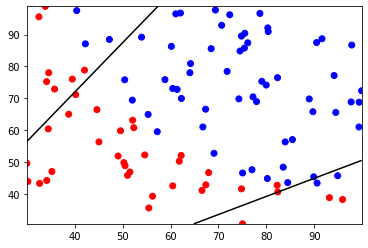

In [256]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [257]:
accuracy_score(Y, clf.predict(X))

0.65